# Initial setup

In [18]:
import sys
from pathlib import Path
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  !git clone https://github.com/Phistian/exjobb
  from google.colab import drive
  drive.mount('/content/drive')
  cur_path = Path("/content/exjobb/miguel/training")
else:
  cur_path = Path(__file__)

parent_path = cur_path.parent.resolve()
spatial_address = str(parent_path) + '/spatial_graphs/'
datasets_address = str(parent_path) + '/datasets/'
sys.path.insert(0, spatial_address)

fatal: destination path 'exjobb' already exists and is not an empty directory.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
%matplotlib inline
!pip install deeptrack --quiet
from importlib import reload
import deeptrack as dt
from deeptrack.models.gnns.graphs import GetEdge
import pandas as pd
import numpy as np

import own_graphs
from own_graphs import GetEdge as custom_ge
from own_graphs import EdgeExtractor as custom_ee
from own_graphs import GraphExtractor as custom_graphE
from own_generators import GraphGenerator as custom_gg
import tensorflow as tf
from tensorflow import keras
import random
import matplotlib.pyplot as plt
own_graphs = reload(own_graphs)
from copy import deepcopy
import logging
logging.disable(logging.WARNING)

# **TRAINING**

# Functions for data handling

In [17]:
def scale_solution(inputdf, a_scale=1, p_scale=1):
    # This function normalizes all separate dimensions of the solution, and optionally adds a scaling factor to the active and/or passive force
    df = inputdf.copy()
    n = df.shape[0]
    maxima = np.zeros(4)
    # finding max
    for i in df.index:
        for j in range(4):
            if maxima[j] < np.abs(df.at[i, "solution"][j]):
                maxima[j] = abs(df.at[i, "solution"][j])
    # scaling
    scales = np.array([a_scale, a_scale, p_scale, p_scale]) / maxima
    for i in df.index:
        for j in range(4):
            df.at[i, "solution"][j] = df.at[i, "solution"][j] * scales[j]

    scales = {"active": scales[0], "passive": scales[2]}
    return df, scales


def set_real_labels(nodesdf):
    last_frame = 0
    label_val = 0
    for i in list(nodesdf.index):
        current_frame = nodesdf.at[i, "frame"]
        if current_frame > last_frame:
            label_val = 0
        nodesdf.at[i, "label"] = label_val
        label_val += 1
        last_frame = current_frame


def shuffle_frames(df):
    dfcpy = df.copy()
    previous_set = df["set"].copy()
    dfgrouping = dfcpy.groupby(["frame"])
    dfs = [_df for _, _df in dfgrouping]
    random.shuffle(dfs)
    catdf = pd.concat(dfs)
    n_rows = catdf.shape[0]
    new_indices = np.arange(n_rows)
    catdf = catdf.set_index(new_indices)
    # catdf["set"] = previous_set.to_numpy()
    return catdf


def setstoframe(df):
    dfcpy = df.copy()
    framecol = deepcopy(dfcpy["frame"])
    dfcpy["set"] = framecol
    return dfcpy

def make_frames_start_at_zero(df):
    dfcpy = df.copy()
    framecol = deepcopy(dfcpy["frame"]).to_numpy()
    minframe = framecol.min()
    new_framecol = framecol - minframe
    dfcpy["frame"] = new_framecol
    return dfcpy

def subset_train_and_val(input_df, val_ratio):
    df = input_df.copy()
    n_particles = int((df.index.max() + 1) / (df.loc[:, "frame"].max() + 1))
    tmp_val_rows = int(val_ratio * df.shape[0])
    i = tmp_val_rows
    while np.mod(i, n_particles) != 0:
        i += 1
    cutoff_index = i
    val_df = df.loc[:cutoff_index - 1, :]
    train_df = df.loc[cutoff_index:, :]
    train_df = make_frames_start_at_zero(train_df)
    train_df = train_df.reset_index(drop=True)
    val_rows = cutoff_index + 1
    return train_df, val_df, val_rows, n_particles


# Load data, make validation split, apply scalings.

In [38]:
## Load data
data_dict = np.load(datasets_address + "/tslj/CPASSIVE N10 samples10 F_P60.npy", allow_pickle=True).item()


## Extract some variables and leave only the dictionary which will be input to the graph extractor
node_labels_dim = len(data_dict["solution"][0])
box_len = data_dict['box_len']
del data_dict['box_len']
interaction_radius = data_dict['interaction_radius']
del data_dict["interaction_radius"]
potential_type = data_dict['potential_type']
del data_dict["potential_type"]


## A pandas dataframe is needed as input to the graph extractor.
nodesdf = pd.DataFrame.from_dict(data_dict)


## Make centroids positive only, with zero in bottom left corner of box
nodesdf.loc[:, "centroid-0"] = nodesdf.loc[:, "centroid-0"] + box_len/2
nodesdf.loc[:, "centroid-1"] = nodesdf.loc[:, "centroid-1"] + box_len/2


## Normalize node centroids and orientations so that max is 1
max_vals = {"centroid-0" : box_len/2, "centroid-1" : box_len/2, "orientation" : np.pi*2, 'frame': nodesdf["frame"].max(), "solution0": nodesdf["solution"]}
for key in ["centroid-0", "centroid-1", "orientation"]:
  nodesdf.loc[:, key] = nodesdf.loc[:, key] / max_vals[key]


## Normalize each column of the solution and ev. add extra scaling to a force type
p_scale = 10
nodesdf, scales = scale_solution(nodesdf, p_scale=p_scale)


## Set the labels so that each particle always has one unique label index
nodesdf.loc[:, "label"] = 0
set_real_labels(nodesdf)


## Cut out a validation set, the rest is the training set.
val_ratio = 0.1
train_nodesdf, val_nodesdf, val_rows, n_particles = subset_train_and_val(nodesdf, val_ratio)


## Set the sets so that each frame is seen as one video
#train_nodesdf = setstoframe(train_nodesdf)


## Shuffle the frames in the training set, and re-index
#train_nodesdf = shuffle_frames(train_nodesdf)


## Set the frames so that the first one is 0 (After the validation split, the frames of the training data might not start at 0)
train_nodesdf = make_frames_start_at_zero(train_nodesdf)


## Scale the box length and interaction length as much as the centroids
scaled_interaction_radius = interaction_radius/max_vals["centroid-0"]  # The length at which the potential has come close to 0 (this length is 3 in the simulations).
scaled_box_len = box_len/max_vals["centroid-0"]
scaled_lengths_dict = {"length_scale": 2/box_len, "box_len": scaled_box_len, "interaction_radius": scaled_interaction_radius, "max_x": box_len/2, "max_y": box_len/2, "max_orientation": 1}

## Set search radius to be used in graph generators to the radius where particle interaction stops
radius = scaled_interaction_radius
print(f"Scaled interaction radius becomes {scaled_interaction_radius} length units, with box length {scaled_box_len}")



IndexError: ignored

# ------------
# Testing graphs 

In [ ]:

train_graph = own_graphs.GraphExtractor(
    train_nodesdf, 
    properties=['centroid-0', 'centroid-1', 'orientation'], 
    radius=radius, box_len=scaled_box_len,
    output_type='nodes'
    ) 

Creating graph edges...


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


In [ ]:
generator = dt.models.gnns.generators.GraphGenerator(
    train_nodesdf, 
    properties=['centroid-0', 'centroid-1', 'orientation'], 
    radius=radius, box_len=scaled_box_len, 
    min_data_size=511, 
    max_data_size=512, 
    max_epochs_per_sample=1
    ) 



Creating graph edges...


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


# ------------

# Set up GNN model

In [21]:
model = dt.models.gnns.MPNGNN(
    dense_layer_dimensions = (64, 96,), 
    base_layer_dimensions = (96, 96, 96),
    number_of_node_features=3, #remember to change to 3
    number_of_edge_outputs=1,
    number_of_edge_features=1,
    number_of_node_outputs = 2, #remember to change to 4
    output_type = 'nodes',
    node_output_activation='linear',
)

# previous model had setup 10 20 40     40 40
# the model that gave 0 all the time was 64 96   96 96 96
# then, learning rate was at 0.001, testing 0.0001

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # dont know if last run had this lr or a smaller one
    loss = 'mae',
    #metrics=['accuracy'], # apparently accuracy gives a type error somewhere
)



# Set up for validation info during training and plotting during training

In [22]:

def setup_validation_data(val_nodesdf):
    graph = own_graphs.GraphExtractor(
        val_nodesdf, ["centroid-0", "centroid-1", "orientation"], radius=radius, output_type='nodes', box_len=scaled_box_len
    )

    v = [
        np.expand_dims(graph[0][0], 0),
        np.expand_dims(graph[0][1], 0),
        np.expand_dims(graph[0][2], 0),
        np.expand_dims(graph[0][3], 0),
    ]

    
    return v

In [23]:
plotter1 = dt.visualization.training.TrainingLossPlotter(loss_names=["loss"])
callback = dt.visualization.callbacks.VisualizationCallback(plotters=[plotter1]),# plotter2])
tf.metrics.get("mae")

<function keras.losses.mean_absolute_error(y_true, y_pred)>

In [33]:
val_data = setup_validation_data(val_nodesdf)
val_solutions = val_nodesdf["solution"].to_list()#[1199-12:-1]
n_batches = int(val_rows/n_particles)
#val_targets = np.reshape(np.array(val_targets), (n_batches, n_particles) + (np.array(val_targets).shape[-1],))
val_targets = np.zeros((n_batches, n_particles, node_labels_dim))
for i in range(n_batches):
    for j in range(n_particles):
        val_targets[i,j,:] = val_solutions[i*n_particles + j]
val_targets = np.expand_dims(val_solutions, axis=0)

Creating graph edges...


100%|██████████| 1/1 [00:00<00:00, 14.11it/s]


# Functions used in model training

In [34]:
def mae(a,b):
    sum = 0
    for i in range(len(a[0])):
        sum += np.linalg.norm(a[0,i,:] - b[0,i,:], ord=2)
    return sum/(i+1)/4
mae(model(val_data), val_targets)

def shuffle_and_reset_generator(df):
    #df = shuffle_frames(train_nodesdf)    
    generator = custom_gg(
        df, 
        properties=['centroid', 'orientation'], 
        radius=scaled_interaction_radius, 
        box_len=scaled_interaction_radius, 
        min_data_size=95, 
        max_data_size=96, 
        output_type='nodes',
    ) 
    return generator
    

InvalidArgumentError: ignored

# Train model

In [35]:
generator = dt.models.gnns.generators.GraphGenerator(
        train_nodesdf, 
        properties=['centroid-0', 'centroid-1', 'orientation'], 
        radius=scaled_interaction_radius, 
        box_len=scaled_interaction_radius, 
        min_data_size=95, 
        max_data_size=96, 
        output_type='nodes',
        nofframes=3
    ) 

Creating graph edges...


100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


Generating 96 / 95 samples before starting training
Epoch 1/200


InvalidArgumentError: ignored

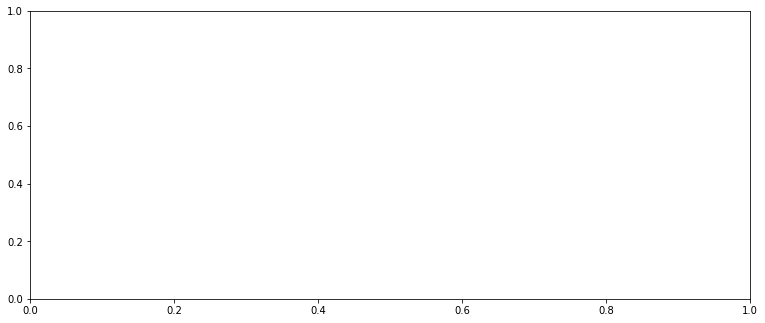

In [37]:
with generator:
  history = model.fit(generator, epochs = 200, callbacks=[callback])

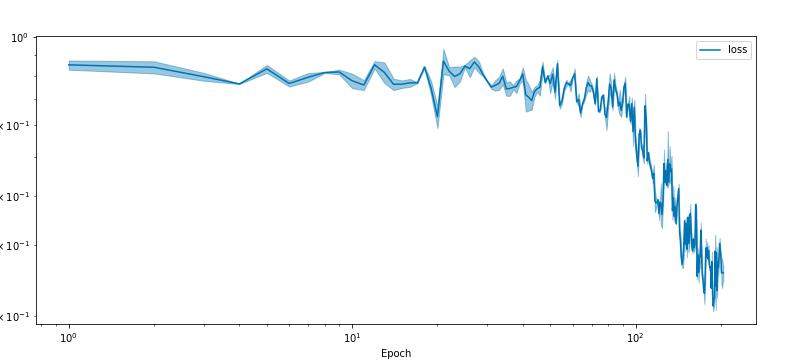

2/2 [==============================] - 1s 402ms/step - loss: 0.2452
Validation loss: 0.3218513753797327 at iteration 15
Creating graph edges...


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Generating 96 / 95 samples before starting training


/usr/local/lib/python3.9/dist-packages/deeptrack/image.py:317: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(self.to_numpy()._value)


ValueError: ignored

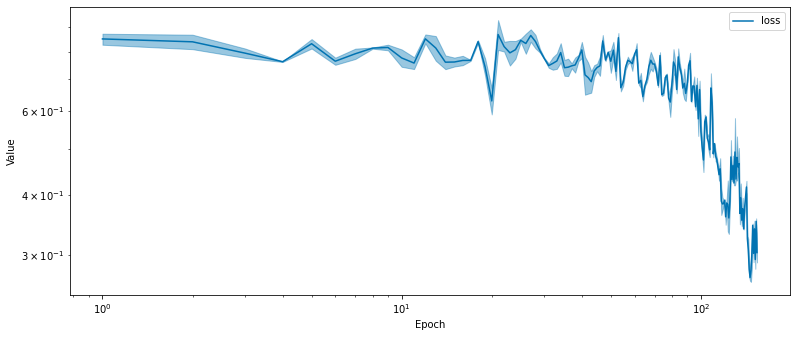

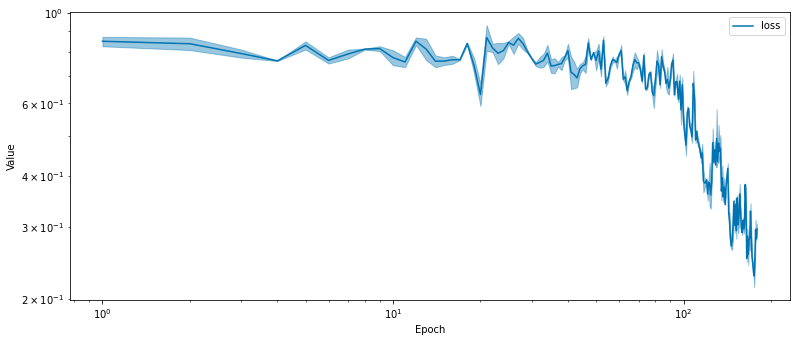

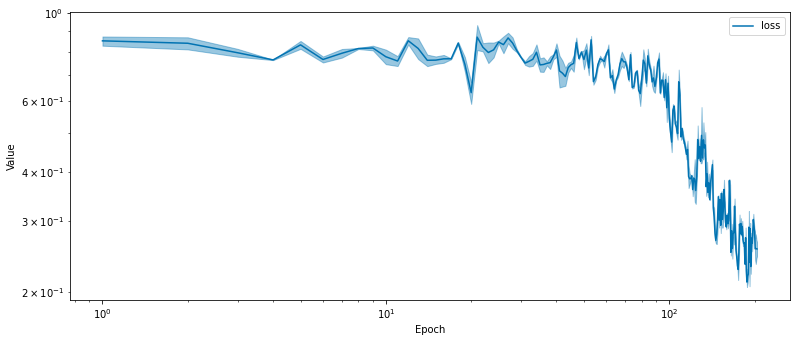

In [ ]:

n_breaks = 4
n_epochs = 100
n_sub_epochs = int(n_epochs/n_breaks)
validation_history = []
histories = []
for i in range(n_breaks):
    val_err = mae(model(val_data), val_targets)
    print(f"Validation loss: {val_err} at iteration {(i+1)*n_breaks - 1}")
    validation_history.append(val_err)
    generator = shuffle_and_reset_generator(train_nodesdf)
    with generator:
        history = model.fit(generator, epochs=n_sub_epochs, callbacks=[callback])
    histories.append(history)
    

# Save history data

In [ ]:
from absl.flags import FlagHolder
for i in range(len(histories)):
  history = histories[i]
  hist_df = pd.DataFrame(history.history)
  
  hist_csv_file = f'/content/drive/MyDrive/EXJOBB/training/miguel/histories/histories1/history{i}.csv'
  with open(hist_csv_file, mode='w') as f:
      hist_df.to_csv(f)

# Plot and save validation data

In [ ]:
val_txt = f'/content/drive/MyDrive/EXJOBB/training/miguel/validation_histories/valhist1.txt'
with open(val_txt, "w") as output:
  output.write(str(validation_history))

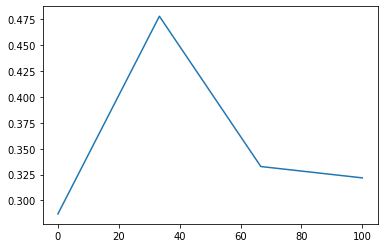

In [ ]:
plt.plot(np.linspace(0, n_epochs, n_breaks), validation_history)

# **EVALUATION**

# Passive force

Passive force test data set up

In [ ]:
## Load test data where two particles move towards each other
test_data_dict = np.load("/content/drive/MyDrive/EXJOBB/datasets/Test/tslj/passiveFP60.npy", allow_pickle=True).item()


## Extract needed misc info and remove rest
test_interaction_radius = test_data_dict['interaction_radius']
test_box_len = test_data_dict['box_len']
del test_data_dict['box_len']
del test_data_dict["interaction_radius"]
del test_data_dict["potential_type"]


## Make into dataframe
test_nodesdf = pd.DataFrame.from_dict(test_data_dict)


## Scale centroids an box length so that the interaction_radius is the same as the model was trained on.
test_max_vals = {"centroid-0" : box_len/2, "centroid-1" : box_len/2, "orientation" : np.pi*2, 'frame': test_nodesdf["frame"].max()} # Must be same box length that the model was trained on
for key in ["centroid-0", "centroid-1", "orientation"]:
  test_nodesdf.loc[:, key] = test_nodesdf.loc[:, key] / test_max_vals[key]
test_scaled_interaction_radius = test_interaction_radius/(box_len/2)
test_scaled_box_len = test_box_len/(box_len/2)


## Make sure that the particles interact at the same distance in the training data and the test data.
if scaled_interaction_radius != test_scaled_interaction_radius:
  raise Exception(f" Training interaction radius {scaled_interaction_radius} vs validation interaction radius {test_scaled_interaction_radius}. Scaling is not the same.")


## Set labels correctly
test_nodesdf.loc[:, "label"] = 0
set_real_labels(test_nodesdf)

In [ ]:
full_test_graph = custom_graphE(
    test_nodesdf, ["orientation", "centroid-0", "centroid-1"], radius=test_scaled_interaction_radius, output_type='nodes', box_len=test_scaled_box_len
)
distances = full_test_graph[0][1]
true_active = full_test_graph[1][0][2:,0]
true_passive = full_test_graph[1][0][2:,2]
edges = full_test_graph[0][2][:, 2:]
v = [
    np.expand_dims(full_test_graph[0][0], 0),
    np.expand_dims(full_test_graph[0][1], 0),
    np.expand_dims(full_test_graph[0][2], 0),
    np.expand_dims(full_test_graph[0][3], 0),
]

model_predictions = model(v).numpy()
model_predictions[0, :, 0] = model_predictions[0, :, 0] / scales["active"]
model_predictions[0, :, 1] = model_predictions[0, :, 1] / scales["active"]
model_predictions[0, :, 2] = model_predictions[0, :, 2] / scales["passive"]
model_predictions[0, :, 3] = model_predictions[0, :, 3] / scales["passive"]

Creating graph edges...


100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


In [ ]:
model_predictions[0,:,0]

NameError: ignored

In [ ]:
model_predictions

Text(0, 0.5, 'Force')

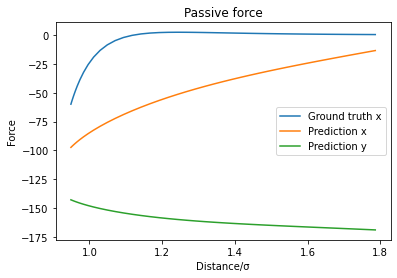

In [ ]:

import matplotlib.pyplot as plt

pred_passive_x = model_predictions[0][:, 2] 
pred_passive_x = pred_passive_x/scales["passive"]
pred_passive_y = model_predictions[0][:, 3]
pred_passive_y = pred_passive_y/scales["passive"]

d_particle_0 = distances[:,0][-100:-1:2]

px_particle_0 = true_passive[-100:-1:2]

pred_px_paritcle_0 = pred_passive_x[-101:-2:2]
pred_py_paritcle_0 = pred_passive_y[-101:-2:2]

plt.plot(d_particle_0*box_len/2, px_particle_0)
plt.plot(d_particle_0*box_len/2, pred_px_paritcle_0)
plt.plot(d_particle_0*box_len/2, pred_py_paritcle_0)
plt.title("Passive force")
plt.legend(["Ground truth x", "Prediction x", "Prediction y"])
plt.xlabel("Distance/\u03C3")
plt.ylabel("Force")